In [1]:
#!pip install image-classifiers
import os
import tensorflow as tf
from keras import callbacks, Model
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras import optimizers
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import random

%matplotlib inline

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Imprimindo algumas imagens da base de treinamento

In [3]:
random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = 'gdrive/My Drive/Colab Notebooks/INF0619_Fuits360/fruits-360'
target_size = (100, 100)

sample_generator = sample_datagen.flow_from_directory(base_path + '/Training',
                                                      target_size=target_size,
                                                      batch_size=25,
                                                      class_mode="sparse")

Found 53197 images belonging to 103 classes.


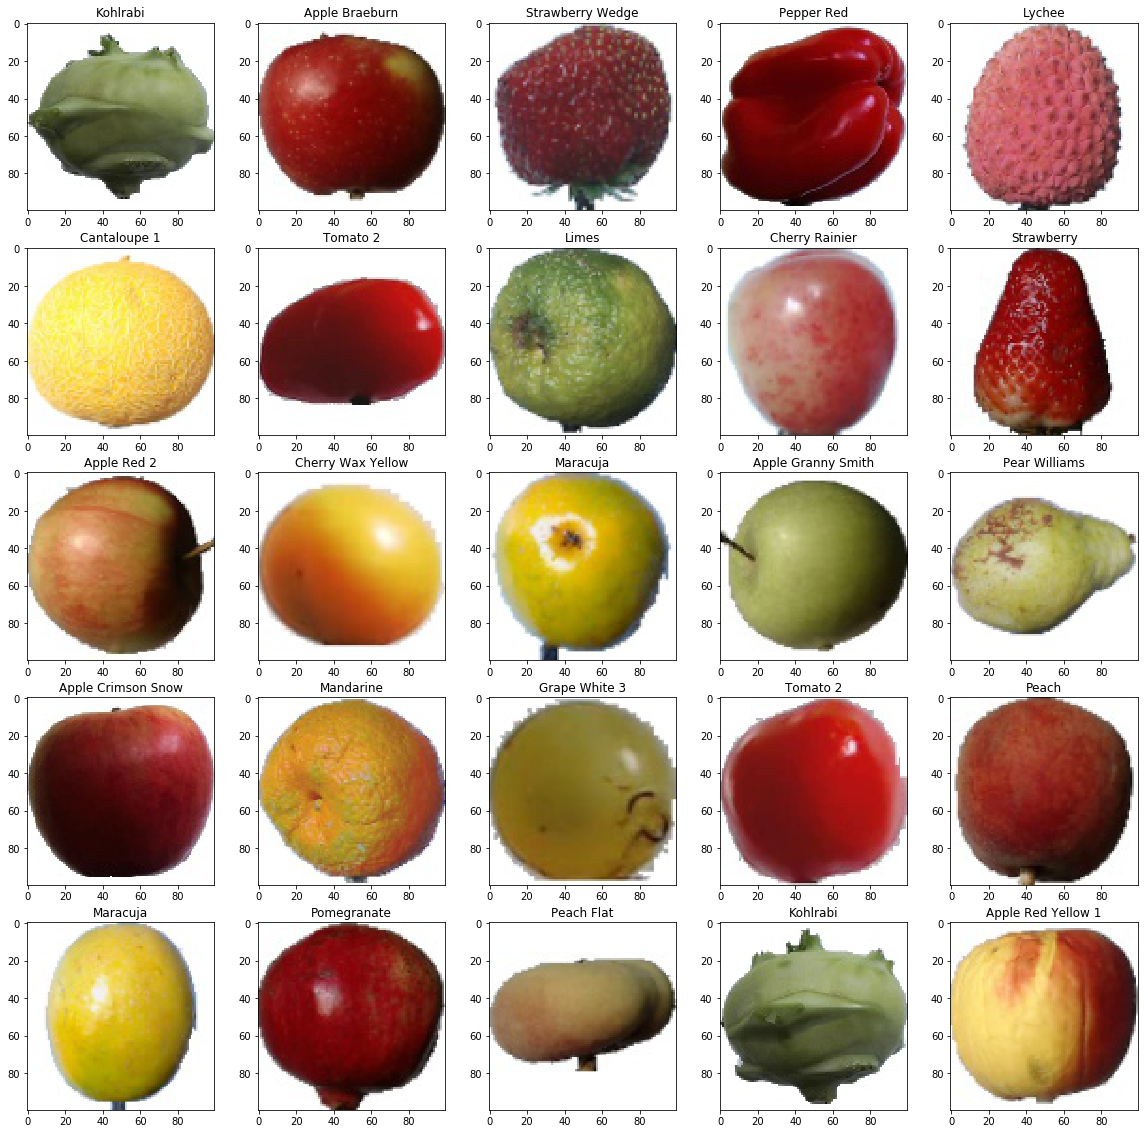

In [4]:
classes = ["Apple Braeburn","Apple Crimson Snow","Apple Golden 1","Apple Golden 2","Apple Golden 3","Apple Granny Smith","Apple Pink Lady","Apple Red 1","Apple Red 2","Apple Red 3",
           "Apple Red Delicious","Apple Red Yellow 1","Apple Red Yellow 2","Apricot","Avocado","Avocado ripe","Banana","Banana Lady Finger","Banana Red","Cactus fruit","Cantaloupe 1",
           "Cantaloupe 2","Carambula","Cherry 1","Cherry 2","Cherry Rainier","Cherry Wax Black","Cherry Wax Red","Cherry Wax Yellow","Chestnut","Clementine","Cocos","Dates","Granadilla",
           "Grape Blue","Grape Pink","Grape White","Grape White 2","Grape White 3","Grape White 4","Grapefruit Pink","Grapefruit White","Guava","Hazelnut","Huckleberry","Kaki","Kiwi",
           "Kohlrabi","Kumquats","Lemon","Lemon Meyer","Limes","Lychee","Mandarine","Mango","Mangostan","Maracuja","Melon Piel de Sapo","Mulberry","Nectarine","Orange","Papaya","Passion Fruit",
           "Peach","Peach 2","Peach Flat","Pear","Pear Abate","Pear Kaiser","Pear Monster","Pear Red","Pear Williams","Pepino","Pepper Green","Pepper Red","Pepper Yellow","Physalis",
           "Physalis with Husk","Pineapple","Pineapple Mini","Pitahaya Red","Plum","Plum 2","Plum 3","Pomegranate","Pomelo Sweetie","Quince","Rambutan","Raspberry","Redcurrant","Salak",
           "Strawberry","Strawberry Wedge","Tamarillo","Tangelo","Tomato 1","Tomato 2","Tomato 3","Tomato 4","Tomato Cherry Red","Tomato Maroon","Tomato Yellow","Walnut"]

x_sample, y_sample = sample_generator.next()
plt.rcParams['figure.figsize'] = (20,20)
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

# Carregando as imagens da base treino e testes
##Utilizaremos 20% da base de treinamento para validação

In [5]:
batch_size = 60

train_datagen = ImageDataGenerator(rescale = 1./255,validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                    target_size = target_size,
                                                    batch_size = batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/Training",
                                                         target_size = target_size,
                                                         batch_size = batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

test_datagen = ImageDataGenerator(rescale = 1./255)
test_generator = test_datagen.flow_from_directory(base_path + "/Test",
                                                  target_size = target_size,
                                                  batch_size = batch_size,
                                                  class_mode = "categorical")

Found 42585 images belonging to 103 classes.
Found 10612 images belonging to 103 classes.
Found 17845 images belonging to 103 classes.


# Parâmetros para treinamento e validação

In [0]:
rms = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

device = '/gpu:0'

epochs = 4

train_steps = train_generator.samples / batch_size

validation_steps = validation_generator.samples / batch_size 

test_steps = test_generator.samples / batch_size

patience = epochs // 3

# Funções de auxílio

In [0]:
df_resultado = pd.DataFrame(columns=["Rede", "train_acc", "val_acc"])
def salvar_resultado(rede, train_acc, val_acc, df):
    df = df.append({"Rede" : rede,
                    "train_acc" : train_acc,
                    "val_acc" : val_acc}, 
                   ignore_index = True)
    return df

In [0]:
def train_model(model, train_g = train_generator, validation_g = validation_generator):
  with tf.device(device):
      return model.fit_generator(generator = train_g,
                                 steps_per_epoch = train_steps,
                                 epochs = epochs,
                                 verbose = 1,
                                 validation_data = validation_g,
                                 validation_steps = validation_steps,
                                 callbacks=[callbacks.TerminateOnNaN(),
                                            callbacks.ReduceLROnPlateau(patience = patience),
                                            callbacks.EarlyStopping(patience = patience,
                                                                    restore_best_weights = True,
                                                                    verbose = 1)])

In [0]:
import seaborn as sns

def acc_loss_model(history_model):
  
  history = pd.DataFrame(history_model.history)

  plt.figure(figsize=(16, 6))
  plt.subplot(121)
  sns.lineplot(data=history[['loss', 'val_loss']])

  plt.subplot(122)
  sns.lineplot(data=history[['acc', 'val_acc']]);

In [0]:
def evaluate_model(model):
  score_train = model.evaluate_generator(generator = train_generator,
                                         steps = train_steps)

  score_val = model.evaluate_generator(generator = validation_generator,
                                       steps = validation_steps)

# Rede *Homemade*

## Definindo a rede

In [11]:
home_made = Sequential()

home_made.add(Conv2D(filters = 10,
                     kernel_size = [3, 3],
                     name = "conv_1",
                     activation = "relu",
                     input_shape = [100, 100, 3]))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_1"))

home_made.add(Conv2D(filters = 20,
                     kernel_size = [3, 3],
                     name = "conv_2",
                     activation = "relu"))

home_made.add(Dropout(rate = 0.5,
                      name = "do_1"))

home_made.add(MaxPool2D(pool_size = [2, 2],
                        name = "pool_2"))

home_made.add(Flatten())

home_made.add(Dense(units = 103,
                    name = "dense_1",
                    activation = 'softmax'))

home_made.compile(optimizer = rms,
                  loss = 'categorical_crossentropy',
                  metrics=['accuracy'])

home_made.summary()

W0720 21:54:07.627150 140369787029376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 21:54:07.629807 140369787029376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 21:54:07.636329 140369787029376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0720 21:54:07.655753 140369787029376 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0720 21:54:07.674157 140369787029376 deprecation_wrapp

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 98, 98, 10)        280       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 49, 49, 10)        0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 47, 47, 20)        1820      
_________________________________________________________________
do_1 (Dropout)               (None, 47, 47, 20)        0         
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 23, 23, 20)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 10580)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 103)               1089843   
Total para

## Treinando o modelo

In [12]:
history_home_made = train_model(home_made)

W0720 21:54:09.067192 140369787029376 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/4
 30/851 [>.............................] - ETA: 5:39:07 - loss: 4.3856 - acc: 0.0739

KeyboardInterrupt: ignored

## Imprimindo resultado do treinamento

In [0]:
acc_loss_model(history_home_made)

In [0]:
evaluate_model(home_made)

# ResNet18 - Transfer Learning

## Feature Extraction

In [0]:
from classification_models.resnet import ResNet18, preprocess_input

ResNet18_model = ResNet18(input_shape = (96,96,3),
                          weights = "imagenet",
                          include_top=False)

for layer in ResNet18_model.layers:
    layer.trainable = False

output = ResNet18_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

ResNet18_model = Model(inputs = ResNet18_model.input,
                       outputs = output)

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = ResNet18_model.fit_generator(generator = train_generator,
                                                  steps_per_epoch = steps_per_epoch,
                                                  epochs = epochs,
                                                  verbose = 1,
                                                  validation_data = validation_generator,
                                                  validation_steps = validation_steps,
                                                  callbacks=[callbacks.TerminateOnNaN(),
                                                             callbacks.ReduceLROnPlateau(patience = patience),
                                                             callbacks.EarlyStopping(patience = patience,
                                                                                     restore_best_weights = True,
                                                                                     verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in ResNet18_model.layers:
    layer.trainable = True

ResNet18_model.compile(loss ='categorical_crossentropy',
                       optimizer = rms,
                       metrics=['accuracy'])

ResNet18_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = ResNet18_model.fit_generator(generator = train_generator,
                                                    steps_per_epoch = steps_per_epoch,
                                                    epochs = epochs,
                                                    verbose = 1,
                                                    validation_data = validation_generator,
                                                    validation_steps = validation_steps,
                                                    callbacks=[callbacks.TerminateOnNaN(),
                                                               callbacks.ReduceLROnPlateau(patience = patience),
                                                               callbacks.EarlyStopping(patience = patience,
                                                                                       restore_best_weights = True,
                                                                                       verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = ResNet18_model.evaluate_generator(generator = train_generator,
                                                steps = validation_steps)

score_val = ResNet18_model.evaluate_generator(generator = validation_generator,
                                              steps = validation_steps)

score_test = ResNet18_model.evaluate_generator(generator = test_generator,
                                               steps = test_steps)

df_resultado = salvar_resultado(rede = "ResNet18 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# VGG16 - Transfer Learning

## Feature Extraction

In [0]:
from keras.layers import Input
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input

VGG16_model = VGG16(input_shape = (96,96,3),
                    weights = "imagenet",
                    include_top = False)

for layer in VGG16_model.layers:
    layer.trainable = False

output = VGG16_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

VGG16_model = Model(inputs = VGG16_model.input,
                    outputs = output)

VGG16_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

VGG16_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = VGG16_model.fit_generator(generator = train_generator,
                                               steps_per_epoch = steps_per_epoch,
                                               epochs = epochs,
                                               verbose = 1,
                                               validation_data = validation_generator,
                                               validation_steps = validation_steps,
                                               callbacks=[callbacks.TerminateOnNaN(),
                                                          callbacks.ReduceLROnPlateau(patience = patience),
                                                          callbacks.EarlyStopping(patience = patience,
                                                                                  restore_best_weights = True,
                                                                                  verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in VGG16_model.layers:
    layer.trainable = True

VGG16_model.compile(loss ='categorical_crossentropy',
                    optimizer = rms,
                    metrics=['accuracy'])

VGG16_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = VGG16_model.fit_generator(generator = train_generator,
                                                 steps_per_epoch = steps_per_epoch,
                                                 epochs = epochs,
                                                 verbose = 1,
                                                 validation_data = validation_generator,
                                                 validation_steps = validation_steps,
                                                 callbacks=[callbacks.TerminateOnNaN(),
                                                            callbacks.ReduceLROnPlateau(patience = patience),
                                                            callbacks.EarlyStopping(patience = patience,
                                                                                    restore_best_weights = True,
                                                                                    verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = VGG16_model.evaluate_generator(generator = train_generator,
                                             steps = validation_steps)

score_val = VGG16_model.evaluate_generator(generator = validation_generator,
                                           steps = validation_steps)

score_test = VGG16_model.evaluate_generator(generator = test_generator,
                                            steps = test_steps)

df_resultado = salvar_resultado(rede = "VGG16 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# InceptionV3 - Transfer Learning

## Feature Extraction

In [0]:
from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input

InceptionV3_model = InceptionV3(input_shape = (96,96,3),
                                weights = "imagenet",
                                include_top = False)

for layer in InceptionV3_model.layers:
    layer.trainable = False

output = InceptionV3_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

InceptionV3_model = Model(inputs = InceptionV3_model.input,
                          outputs = output)

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in InceptionV3_model.layers:
    layer.trainable = True

InceptionV3_model.compile(loss ='categorical_crossentropy',
                          optimizer = rms,
                          metrics=['accuracy'])

InceptionV3_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = InceptionV3_model.fit_generator(generator = train_generator,
                                                       steps_per_epoch = steps_per_epoch,
                                                       epochs = epochs,
                                                       verbose = 1,
                                                       validation_data = validation_generator,
                                                       validation_steps = validation_steps,
                                                       callbacks=[callbacks.TerminateOnNaN(),
                                                                  callbacks.ReduceLROnPlateau(patience = patience),
                                                                  callbacks.EarlyStopping(patience = patience,
                                                                                          restore_best_weights = True,
                                                                                          verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = InceptionV3_model.evaluate_generator(generator = train_generator,
                                                   steps = validation_steps)

score_val = InceptionV3_model.evaluate_generator(generator = validation_generator,
                                                 steps = validation_steps)

score_test = InceptionV3_model.evaluate_generator(generator = test_generator,
                                                  steps = test_steps)

df_resultado = salvar_resultado(rede = "InceptionV3 - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

# MobileNetV2 - Transfer Learning

## Feature Extraction

In [0]:
from keras.applications import MobileNetV2
from keras.applications.mobilenet_v2 import preprocess_input

MobileNet_model = MobileNetV2(input_shape = (96,96,3),
                              weights = "imagenet",
                              include_top = False)

for layer in MobileNet_model.layers:
    layer.trainable = False

output = MobileNet_model.output

output = Flatten(name = 'flat_mdc')(output)

output = Dense(103,
               activation ='softmax',
               name = 'saida_mdc')(output)

MobileNet_model = Model(inputs = MobileNet_model.input,
                        outputs = output)

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_frozen = MobileNet_model.fit_generator(generator = train_generator,
                                                   steps_per_epoch = steps_per_epoch,
                                                   epochs = epochs,
                                                   verbose = 1,
                                                   validation_data = validation_generator,
                                                   validation_steps = validation_steps,
                                                   callbacks=[callbacks.TerminateOnNaN(),
                                                              callbacks.ReduceLROnPlateau(patience = patience),
                                                              callbacks.EarlyStopping(patience = patience,
                                                                                      restore_best_weights = True,
                                                                                      verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_frozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Feature Extraction",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

## Fine Tuning

In [0]:
for layer in MobileNet_model.layers:
    layer.trainable = True

MobileNet_model.compile(loss ='categorical_crossentropy',
                        optimizer = rms,
                        metrics=['accuracy'])

MobileNet_model.summary()

### Treinando o modelo

In [0]:
with tf.device(device):
    history_unfrozen = MobileNet_model.fit_generator(generator = train_generator,
                                                     steps_per_epoch = steps_per_epoch,
                                                     epochs = epochs,
                                                     verbose = 1,
                                                     validation_data = validation_generator,
                                                     validation_steps = validation_steps,
                                                     callbacks=[callbacks.TerminateOnNaN(),
                                                                callbacks.ReduceLROnPlateau(patience = patience),
                                                                callbacks.EarlyStopping(patience = patience,
                                                                                        restore_best_weights = True,
                                                                                        verbose = 1)])

### Imprimindo resultado do treinamento

In [0]:
import seaborn as sns

history = pd.DataFrame(history_unfrozen.history)

plt.figure(figsize=(16, 6))
plt.subplot(121)
sns.lineplot(data=history[['loss', 'val_loss']])

plt.subplot(122)
sns.lineplot(data=history[['acc', 'val_acc']]);

score_train = MobileNet_model.evaluate_generator(generator = train_generator,
                                                 steps = validation_steps)

score_val = MobileNet_model.evaluate_generator(generator = validation_generator,
                                               steps = validation_steps)

score_test = MobileNet_model.evaluate_generator(generator = test_generator,
                                                steps = test_steps)

df_resultado = salvar_resultado(rede = "MobileNet - Fine Tuning",
                                train_acc = score_train[1],
                                val_acc = score_val[1],
                                test_acc = score_test[1],
                                df = df_resultado)

In [0]:
df_resultado.sort_values(by=["Rede"])